## ETL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


In [2]:
# Load the labeled data
good_examples = pd.read_csv('./InDaS Labeled/good_period_2024_01_03.csv')
good_examples

bad_examples = pd.read_csv('./InDaS Labeled/bad_period_2024_01_06.csv')
bad_examples

all_good_segments = []
all_bad_segments = []

In [3]:
# Apply the indicator function to create a new column
good_examples['indicator'] = good_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_good = good_examples.index[good_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_good.append(len(good_examples))


# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_good)-1):
    good_segment = good_examples.iloc[start_indices_good[i]:start_indices_good[i + 1]]
    all_good_segments.append(good_segment)

print("Total Good Cutting Data:", len(all_good_segments))
print("Shape of Segment 1:", all_good_segments[0].shape)
print("Shape of Torque Data:", all_good_segments[0]['Torque'].shape)


Total Good Cutting Data: 4552
Shape of Segment 1: (1668, 11)
Shape of Torque Data: (1668,)


In [4]:
# Apply the indicator function to create a new column
bad_examples['indicator'] = bad_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_bad = bad_examples.index[bad_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_bad.append(len(bad_examples))

# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_bad)-1):
    segment = bad_examples.iloc[start_indices_bad[i]:start_indices_bad[i + 1]]
    all_bad_segments.append(segment)

print("Total Bad Cutting Data:", len(all_bad_segments))
print("Shape of Segment 1:", all_bad_segments[0].shape)
print("Shape of Torque Data:", all_bad_segments[0]['Torque'].shape)


Total Bad Cutting Data: 1937
Shape of Segment 1: (1668, 11)
Shape of Torque Data: (1668,)


In [5]:
# Bad Samples
bad_onramps = list()
bad_cuttings = list()
bad_cleanings = list()
bad_offramps = list()
for i in range(len(all_bad_segments)):
    bad_onramp_segment = all_bad_segments[i].loc[(all_bad_segments[i]['rel_time'] >= 0.0) & (all_bad_segments[i]['rel_time'] <= 0.50)]
    bad_cutting_segment = all_bad_segments[i].loc[(all_bad_segments[i]['rel_time'] > 0.50) & (all_bad_segments[i]['rel_time'] <= 1.60)]
    bad_cleaning_segment = all_bad_segments[i].loc[(all_bad_segments[i]['rel_time'] > 1.60) & (all_bad_segments[i]['rel_time'] <= 3.0)]
    bad_offramp_segment = all_bad_segments[i].loc[(all_bad_segments[i]['rel_time'] > 3.0) & (all_bad_segments[i]['rel_time'] <= 3.5)]

    # Append the segments to the lists
    bad_onramps.append(bad_onramp_segment)
    bad_cuttings.append(bad_cutting_segment)
    bad_cleanings.append(bad_cleaning_segment)
    bad_offramps.append(bad_offramp_segment)

In [6]:
# This function is FUcking up the Classification

# Good Samples
good_onramps = list()
good_cuttings = list()
good_cleanings = list()
good_offramps = list()
# Good Samples
for i in range(len(all_good_segments)):
    good_onramp_segment = all_good_segments[i].loc[(all_good_segments[i]['rel_time'] >= 0.0) & (all_good_segments[i]['rel_time'] <= 0.50)]
    good_cutting_segment = all_good_segments[i].loc[(all_good_segments[i]['rel_time'] > 0.50) & (all_good_segments[i]['rel_time'] <= 1.60)]
    good_cleaning_segment = all_good_segments[i].loc[(all_good_segments[i]['rel_time'] > 1.60) & (all_good_segments[i]['rel_time'] <= 3.0)]
    good_offramp_segment = all_good_segments[i].loc[(all_good_segments[i]['rel_time'] > 3.0) & (all_good_segments[i]['rel_time'] <= 3.5)]

    good_onramps.append(good_onramp_segment)
    good_cuttings.append(good_cutting_segment)
    good_cleanings.append(good_cleaning_segment)
    good_offramps.append(good_offramp_segment)    

# print length of segments
print("Total Bad Onramp Segments:", len(bad_onramps[0]))
print("Total Bad Cutting Segments:", len(bad_cuttings[0]))
print("Total Bad Cleaning Segments:", len(bad_cleanings[0]))
print("Total Bad Offramp Segments:", len(bad_offramps[0]))
print('Total Segments', len(bad_onramps[0]) + len(bad_cuttings[0]) + len(bad_cleanings[0]) + len(bad_offramps[0]))


Total Bad Onramp Segments: 236
Total Bad Cutting Segments: 550
Total Bad Cleaning Segments: 700
Total Bad Offramp Segments: 182
Total Segments 1668


## Convert Time-Series into Spectogram Features

## Scalogram features of Cutting data

In [7]:
import pywt
import cv2

good_scalo_features = list()
bad_scalo_features = list()


scale_resolution = 24

def compute_scalo_spectrogram(data, title, wavelet='cmor', cmap='magma'):
    scales = np.arange(1, scale_resolution)
    #scales = np.linspace(1, 128, scale_resolution)
    coefficients, frequencies = pywt.cwt(data, scales, wavelet)
    power = (abs(coefficients)) ** 2
    
    # Time vector just for plot
    time_vector = np.arange(len(data)) * 0.002
    #print(power.shape, time_vector.shape, scales.shape)
    return power


# Sample number
MAX_SAMPLES_GOOD = 4552
# Sample number
MAX_SAMPLES_BAD = 1936

window = 836
#window = scale_resolution - 1

for i in range(MAX_SAMPLES_GOOD):
    # Scalo y = scale resolution, scalo x = length of torque
    good_cutting_torque = np.asarray(all_good_segments[i]['Torque'])
    good_scalo = compute_scalo_spectrogram(good_cutting_torque, 'good cutting segment')
    # Cut the x axis of good_scalo to 512 (!try extending to 545)
    # Analyzing second rotation
    good_scalo = good_scalo[:, :window]

    #print(good_scalo.shape)
    # Normalize as images
    good_scalo = cv2.normalize(good_scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

    good_scalo_features.append(good_scalo)


    
for i in range(MAX_SAMPLES_BAD):
    bad_cutting_torque = np.asarray(all_bad_segments[i]['Torque'])
    bad_scalo = compute_scalo_spectrogram(bad_cutting_torque, 'bad cutting segment')
    # Analyzing second rotation
    bad_scalo = bad_scalo[:, :window]

    #print(bad_scalo.shape)
    # Normalize as images
    bad_scalo = cv2.normalize(bad_scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
    
    bad_scalo_features.append(bad_scalo)

print("shape of good scalo features", good_scalo_features[0].shape)
print("total good scalo features", len(good_scalo_features))
print("total bad scalo features", len(bad_scalo_features))

# 256 7m11.2s
# 128 1m 54.9s
# 32 11.5s
# 24 8.1s
print(bad_scalo_features[0])

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


shape of good scalo features (23, 836)
total good scalo features 4552
total bad scalo features 1936
[[8.8881300e-04 4.2146519e-05 4.7471956e-05 ... 4.3360022e-04
  1.6988367e-04 5.6527928e-04]
 [2.9870404e-03 6.8463868e-04 4.0552780e-04 ... 5.2258214e-03
  4.7977343e-03 2.7072460e-03]
 [9.0097347e-03 4.5242240e-03 1.3491983e-03 ... 2.1282362e-02
  1.6520841e-02 9.8337121e-03]
 ...
 [2.4465723e-01 1.2327657e-01 4.9570832e-02 ... 5.5898339e-03
  6.3899015e-03 8.2800603e-03]
 [2.4041027e-01 2.7600983e-01 2.3958187e-01 ... 6.7054415e-03
  6.5323985e-03 7.7841021e-03]
 [3.8652819e-01 4.0082255e-01 2.0596235e-01 ... 8.7189460e-03
  8.5737798e-03 6.0067177e-03]]


## Plot the feature to the CNN Input

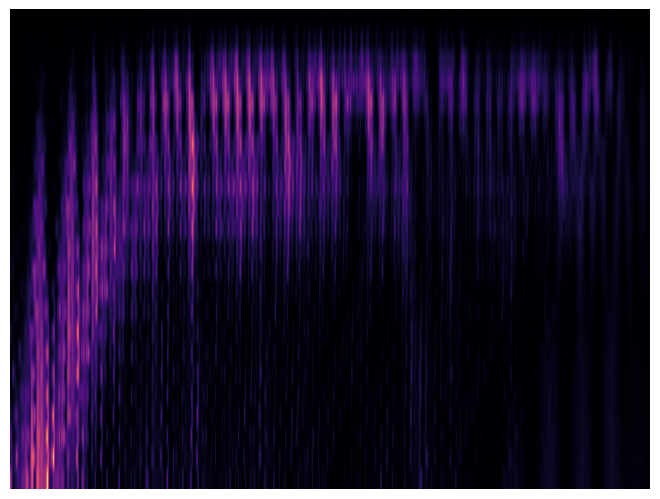

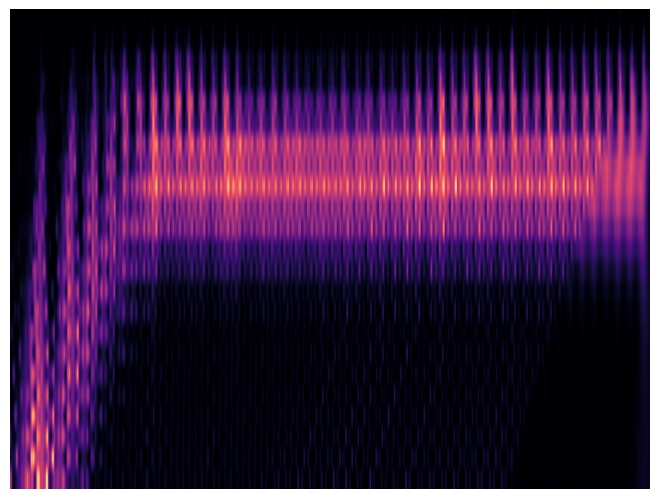

In [8]:
# Which Sample to View
S = 1000
cmap = 'magma'
# Example to view one scalogram as an image using OpenCV
temp = np.asarray(bad_scalo_features[S])

# Normalize the data to 0-255 for display
temp_normalized = cv2.normalize(temp, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
temp_normalized = temp_normalized.astype(np.uint8)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(temp_normalized, cmap, aspect='auto')
plt.show()


# Example to view one scalogram as an image using OpenCV
temp = np.asarray(good_scalo_features[S])

# Normalize the data to 0-255 for display
temp_normalized = cv2.normalize(temp, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
temp_normalized = temp_normalized.astype(np.uint8)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(temp_normalized, cmap, aspect='auto')
plt.show()

## Undersample Classes to Balance Them

### Scalo Features

In [9]:

print("Good Scalo Features Shape:", len(good_scalo_features))
print("Bad Scalo Features Shape:", len(bad_scalo_features))
print("Good Scalo Features Shape:", good_scalo_features[0].shape)
SAMPLES_FOR_TRAINING = 1900
balanced_good_scalo_features = np.array(good_scalo_features[:SAMPLES_FOR_TRAINING])
balanced_bad_scalo_features = np.array(bad_scalo_features[:SAMPLES_FOR_TRAINING])

validation_good_scalo_features = np.array(good_scalo_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_GOOD])
validation_bad_scalo_features = np.array(bad_scalo_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_BAD])

validation_good_scalo_labels = np.ones(validation_good_scalo_features.shape[0])
validation_bad_scalo_labels = np.zeros(validation_bad_scalo_features.shape[0])

validation_scalo_features = np.concatenate((validation_good_scalo_features, validation_bad_scalo_features), axis=0)
validation_scalo_labels = np.concatenate((validation_good_scalo_labels, validation_bad_scalo_labels), axis=0)
print("scalo Features Val Shape:", validation_scalo_features.shape)
print("Balanced_Good", balanced_good_scalo_features.shape)
print("Balanced_Bad", balanced_bad_scalo_features.shape)

# SAMPLES_FOR_TRAINING = 1900
# balanced_good_scalo_features = np.zeros((MAX_SAMPLES_GOOD, 23, 512))
# balanced_bad_scalo_features = np.zeros((MAX_SAMPLES_GOOD, 23, 512))

# validation_good_scalo_features = np.zeros((MAX_SAMPLES_GOOD - SAMPLES_FOR_TRAINING, 23, 512))
# validation_bad_scalo_features = np.zeros((MAX_SAMPLES_GOOD - SAMPLES_FOR_TRAINING, 23, 512))
# # FIXME: Redo the way you append to balaced datasets

# for i in range(SAMPLES_FOR_TRAINING):
#     balanced_good_scalo_features[i] = good_scalo_features[i]
#     balanced_bad_scalo_features[i] = bad_scalo_features[i]

# for i in range(SAMPLES_FOR_TRAINING, MAX_SAMPLES_GOOD):
#     validation_good_scalo_features[i - SAMPLES_FOR_TRAINING] = good_scalo_features[i]
#     validation_bad_scalo_features[i - SAMPLES_FOR_TRAINING] = bad_scalo_features[i]
    
# # Create the labels for the balanced dataset
# balanced_good_scalo_labels = np.ones(balanced_good_scalo_features.shape[0])
# balanced_bad_scalo_labels = np.zeros(balanced_bad_scalo_features.shape[0])

# # Create the labels for the validation dataset
# validation_good_scalo_labels = np.ones(validation_good_scalo_features.shape[0])
# validation_bad_scalo_labels = np.zeros(validation_bad_scalo_features.shape[0])

# Concatenate the features and labels

Good Scalo Features Shape: 4552
Bad Scalo Features Shape: 1936
Good Scalo Features Shape: (23, 836)
scalo Features Val Shape: (2688, 23, 836)
Balanced_Good (1900, 23, 836)
Balanced_Bad (1900, 23, 836)


## PCA & TSNE

Reshaped all_features shape: (3800, 19228)


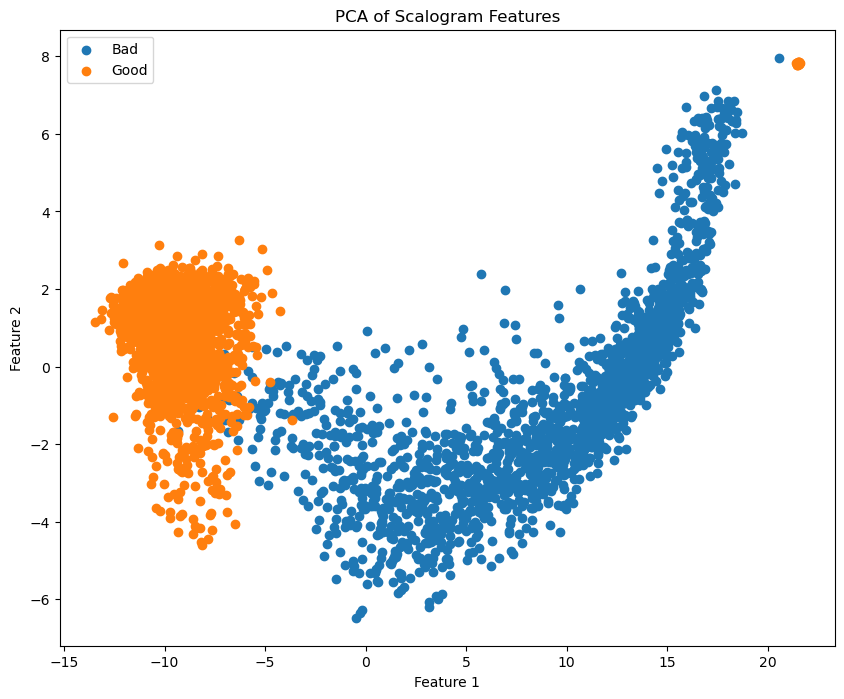

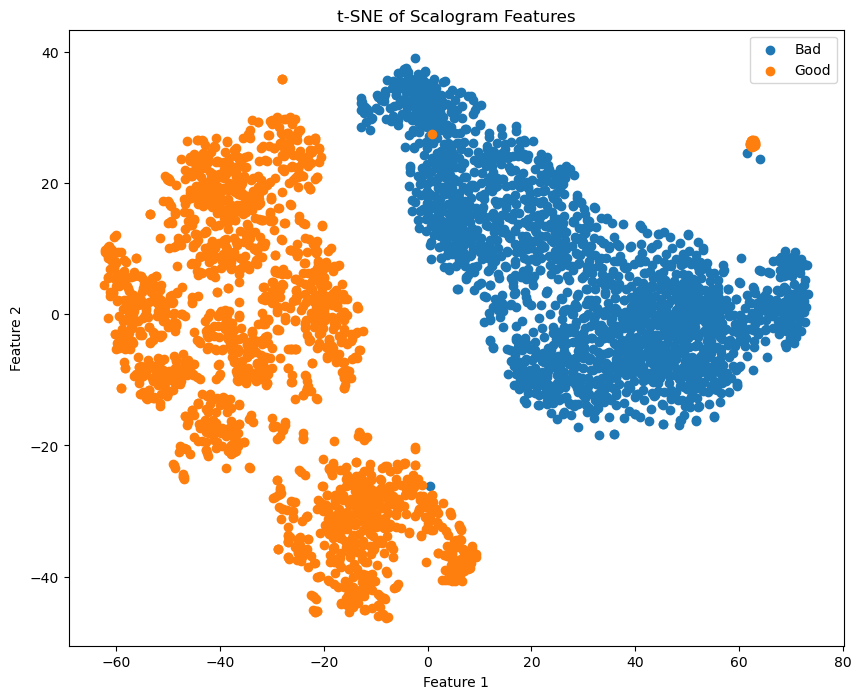

Explained variance ratio: [0.6763753  0.03247297]
Total explained variance: 0.7088482975959778


In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reshape the 3D data to 2D
def reshape_3d_to_2d(data):
    return data.reshape(data.shape[0], -1)

# Combine and reshape good and bad features
reshaped_good = reshape_3d_to_2d(balanced_good_scalo_features)
reshaped_bad = reshape_3d_to_2d(balanced_bad_scalo_features)
all_features = np.concatenate((reshaped_good, reshaped_bad), axis=0)
labels = np.concatenate((np.ones(reshaped_good.shape[0]), 
                         np.zeros(reshaped_bad.shape[0])))

print("Reshaped all_features shape:", all_features.shape)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_features)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_features)

# Plotting function
def plot_embedding(X, y, title):
    plt.figure(figsize=(10, 8))
    for i, label in zip([0, 1], ['Bad', 'Good']):
        plt.scatter(X[y == i, 0], X[y == i, 1], label=label)
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

# Plot PCA results
plot_embedding(pca_result, labels, 'PCA of Scalogram Features')

# Plot t-SNE results
plot_embedding(tsne_result, labels, 't-SNE of Scalogram Features')

# Print explained variance ratio for PCA
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", sum(pca.explained_variance_ratio_))

## Analyzing "Good" and "Bad" Clusters individually

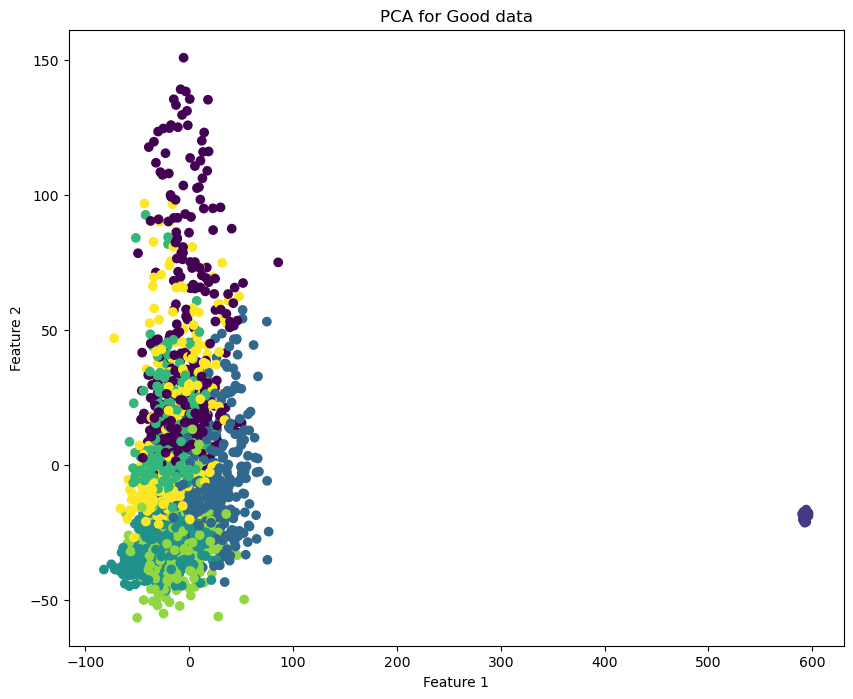

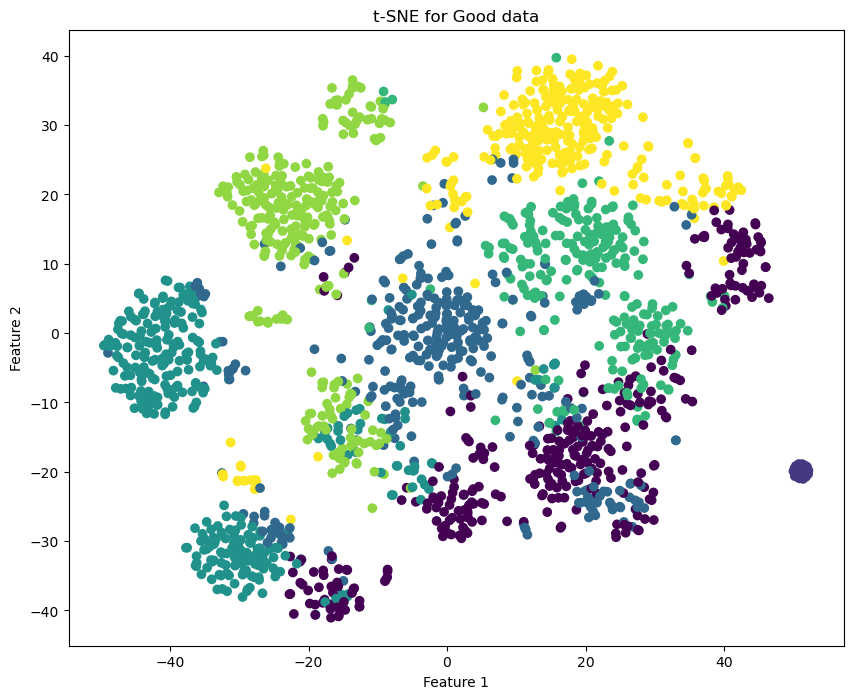

Explained variance ratio (PCA) for Good data: [0.25815302 0.05806891]


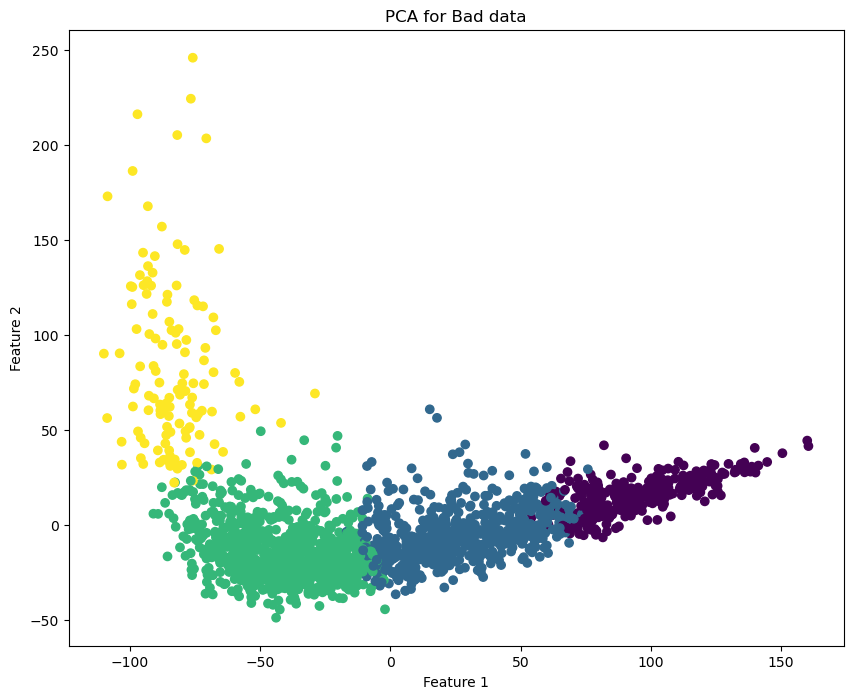

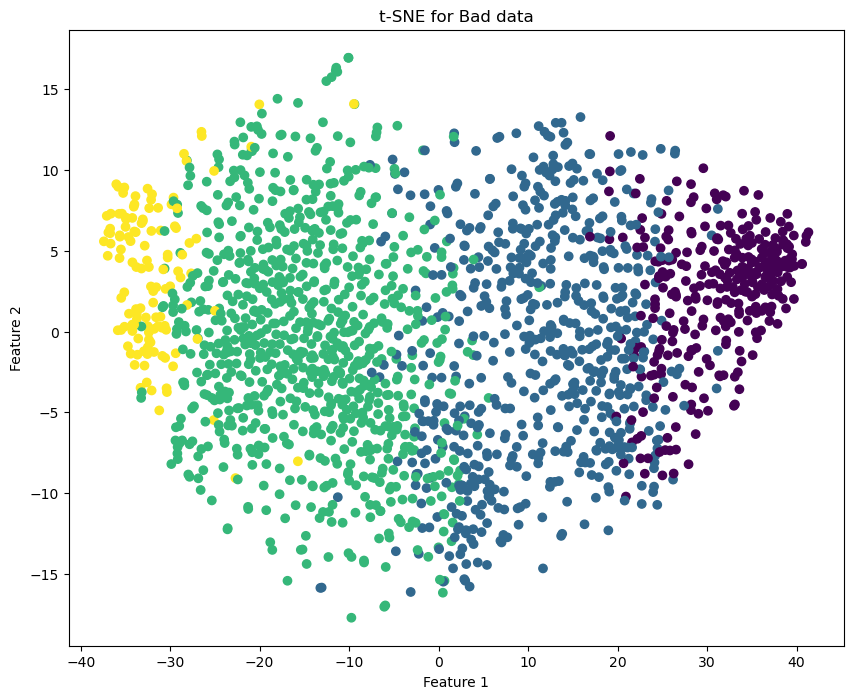

Explained variance ratio (PCA) for Bad data: [0.170519   0.04677542]


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def analyze_subclusters(features, label, n_clusters=3):
    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features_scaled)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features_scaled)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features_scaled)
    
    # Plotting function
    def plot_result(data, title, cluster_labels):
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='viridis')
        #plt.colorbar(scatter)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f'{title} for {label} data')
        plt.show()
    
    # Plot results
    plot_result(pca_result, 'PCA', cluster_labels)
    plot_result(tsne_result, 't-SNE', cluster_labels)
    
    print(f"Explained variance ratio (PCA) for {label} data:", pca.explained_variance_ratio_)

# Assuming you have your data split into good_features and bad_features
analyze_subclusters(reshape_3d_to_2d(balanced_good_scalo_features), "Good", 7)
analyze_subclusters(reshape_3d_to_2d(balanced_bad_scalo_features), "Bad", 4)

Clusttering 4552 samples


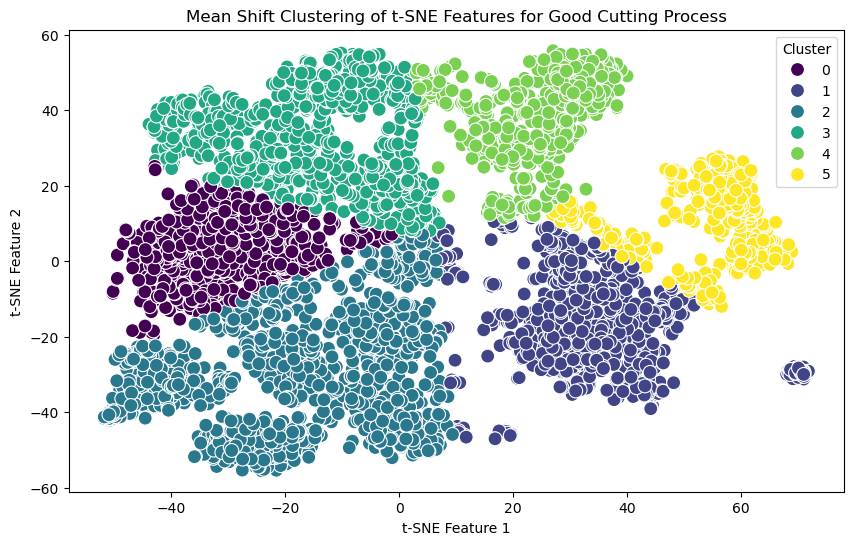

In [12]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Guess provided by Bosch 
# K is not needed for Mean Shift
good_features = np.asarray(good_scalo_features)
print(f"Clusttering {len(good_features)} samples")

# Reshape the selected good features to 2D (if needed)
good_features_reshaped = good_features.reshape(good_features.shape[0], -1)

# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(good_features_reshaped)

# Estimate the bandwidth for Mean Shift
bandwidth = estimate_bandwidth(tsne_results, quantile=0.1)

# Perform Mean Shift clustering on the t-SNE results
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift_labels = mean_shift.fit_predict(tsne_results)

# Visualize the t-SNE results with clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=mean_shift_labels, palette='viridis', s=100, alpha=1.0)
plt.title('Mean Shift Clustering of t-SNE Features for Good Cutting Process')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

Clusttering 1936 samples


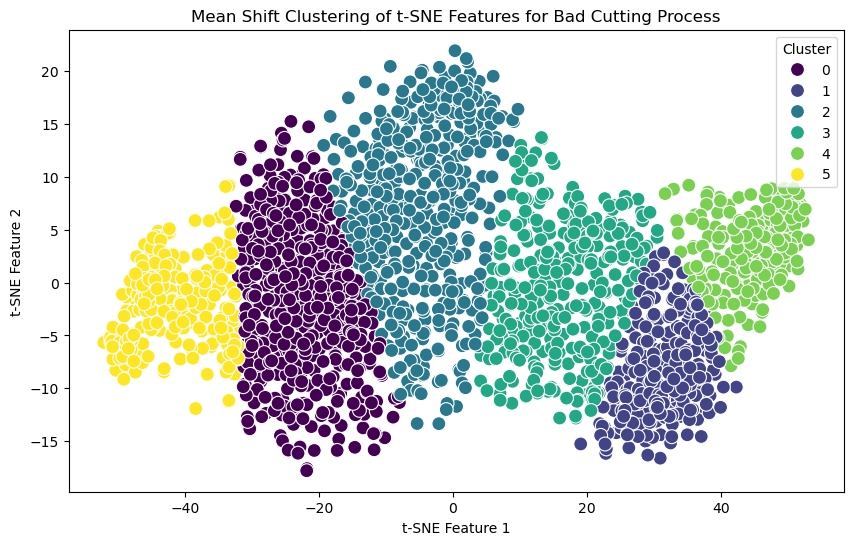

In [13]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Guess provided by Bosch 
# K is not needed for Mean Shift
good_features = np.asarray(bad_scalo_features)
print(f"Clusttering {len(good_features)} samples")

# Reshape the selected good features to 2D (if needed)
good_features_reshaped = good_features.reshape(good_features.shape[0], -1)

# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(good_features_reshaped)

# Estimate the bandwidth for Mean Shift
bandwidth = estimate_bandwidth(tsne_results, quantile=0.1)

# Perform Mean Shift clustering on the t-SNE results
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift_labels = mean_shift.fit_predict(tsne_results)

# Visualize the t-SNE results with clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=mean_shift_labels, palette='viridis', s=100, alpha=1.0)
plt.title('Mean Shift Clustering of t-SNE Features for Bad Cutting Process')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

## Random Forrest Classifier

Classification Report:
              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00       740
        Good       1.00      1.00      1.00       780

    accuracy                           1.00      1520
   macro avg       1.00      1.00      1.00      1520
weighted avg       1.00      1.00      1.00      1520



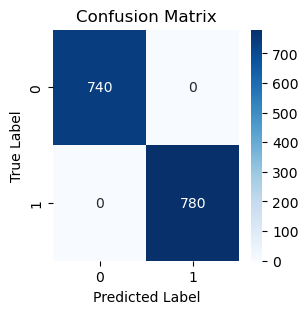

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data in the following format:
# all_features: your combined and reshaped features
# labels: your labels (0 for bad, 1 for good)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.4, random_state=42)

# Create and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Bad', 'Good']))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Load Unlabeled Data

In [67]:
import json
# All: 40000 rows, 50%: 20000 rows, 10%: 4000 rows
nr_rows = 30000


df = pd.read_csv('all.csv', nrows=nr_rows)
#print(df.head())

# Extract torque and angle outside the loop
torque_data = df["Torque"].apply(json.loads)
angle_data = df["Angle"].apply(json.loads)

torque_array = []
whole_rotation = []
first_rotation = []
second_rotation = []

for sample in range(0, nr_rows):
    torque = pd.DataFrame(torque_data[sample][0]['Rows'], columns=["Time", "Torque"])
    torque = torque.drop(columns=["Time"])
    angle = pd.DataFrame(angle_data[sample][0]['Rows'], columns=["Time", "Angle"])

    total_data = pd.concat([angle, torque], axis=1)
    total_data['Kleiner_als_vorher'] = total_data["Angle"] > total_data["Angle"].shift(1)
    total_data['Kumulatives_Produkt'] = (total_data['Kleiner_als_vorher'][1:].astype(int)).cumprod()

    resultat = total_data[total_data['Kumulatives_Produkt'] == 1]
    resultat2 = total_data[total_data['Kumulatives_Produkt'] == 0]
    resultat2 = resultat2.reset_index()

    resultat = resultat.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    resultat2 = resultat2.drop(columns=["Time", "index", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])

    # Ensure both dataframes have the same shape by truncating or padding
    whole_len = 1800
    max_len = 836  # Define the target length
    resultat = resultat.head(max_len).reindex(range(max_len), fill_value=0)
    resultat2 = resultat2.head(max_len).reindex(range(max_len), fill_value=0)


    first_rotation.append(resultat)
    second_rotation.append(resultat2[30:836])

    total_data = total_data.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    total_data = total_data.head(max_len).reindex(range(whole_len), fill_value=0)
    whole_rotation.append(total_data)

    torque_array.append(torque)

# First Rotation
data = np.array(first_rotation)
first_rotations = np.squeeze(data)

# Second Rotation - The rotatiion where Frequencies are different
data2 = np.array(second_rotation)
second_rotations = np.squeeze(data2)

# Whole Rotation
data3 = np.array(whole_rotation)
whole_rotation_arr = np.squeeze(data3)

print(f"loaded first rotations: {len(first_rotations)}")

loaded first rotations: 30000


## Subsample Randomly

In [168]:
from sklearn.utils import shuffle
import pywt
import cv2


# Randomly subsample 5000 points
subsample_size = 5000
print("before subsamp", first_rotations[0].shape)
# Shuffle and subsample first_rotations
first_rotations_subsampled = shuffle(first_rotations, random_state=42)[:subsample_size]
print("after subsamp", first_rotations_subsampled[0].shape)



unlabelled_scalo_features = list()

scale_resolution = 24

def compute_scalo_spectrogram(data, title, wavelet='cmor', cmap='magma'):
    scales = np.arange(1, scale_resolution)
    coefficients, frequencies = pywt.cwt(data, scales, wavelet)
    power = (abs(coefficients)) ** 2
    return power


for s in first_rotations_subsampled:
    
    cutting_scalo = compute_scalo_spectrogram(s, 'good cutting segment')

    #print(cutting_scalo.shape)
    # Normalize as images
    cutting_scalo = cv2.normalize(cutting_scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

    unlabelled_scalo_features.append(cutting_scalo)

print(unlabelled_scalo_features[0].shape)
print(len(unlabelled_scalo_features))

before subsamp (836,)
after subsamp (836,)


/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


(23, 836)
5000


## Extract first rotation and compute scalogram features

In [169]:
# import pywt
# import cv2


# unlabelled_scalo_features = list()

# scale_resolution = 24

# def compute_scalo_spectrogram(data, title, wavelet='cmor', cmap='magma'):
#     scales = np.arange(1, scale_resolution)
#     coefficients, frequencies = pywt.cwt(data, scales, wavelet)
#     power = (abs(coefficients)) ** 2
#     return power


# for i in range(nr_rows):
    
#     cutting_scalo = compute_scalo_spectrogram(first_rotations[i], 'good cutting segment')

#     #print(cutting_scalo.shape)
#     # Normalize as images
#     cutting_scalo = cv2.normalize(cutting_scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

#     unlabelled_scalo_features.append(cutting_scalo)

# print(unlabelled_scalo_features[0].shape)
# print(len(unlabelled_scalo_features))

## Classify Scalogram and create labels using random forrest model trained

In [170]:
unlabelled_scalo_features = np.array(unlabelled_scalo_features)
# Reshape the unlabelled data to match the classifier input
#unlabelled_scalo_features_reshaped = unlabelled_scalo_features.reshape(nr_rows, -1)
unlabelled_scalo_features_reshaped = reshape_3d_to_2d(unlabelled_scalo_features)

# Make predictions on the unlabelled data
predictions = rf_classifier.predict(unlabelled_scalo_features_reshaped)

# Count the number of good and bad predictions
good_predictions = np.sum(predictions == 1)
bad_predictions = np.sum(predictions == 0)

print(f"Number of Good Predictions: {good_predictions}")
print(f"Number of Bad Predictions: {bad_predictions}")


Number of Good Predictions: 3092
Number of Bad Predictions: 1908


## TSNE & K-Means Cluster only Good Predictions

In [171]:
# import numpy as np
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# import seaborn as sns


# # Initial Guess provided by Bosch 
# K = 6

# # Select only the good predictions
# good_indices = np.where(predictions == 1)[0]
# good_features = unlabelled_scalo_features[good_indices]

# # Reshape the selected good features to 2D (if needed)
# good_features_reshaped = good_features.reshape(good_features.shape[0], -1)
# print("Good Features Shape:", good_features.shape, good_features_reshaped.shape)
# # Perform t-SNE analysis
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(good_features_reshaped)

# # Perform k-means clustering on the t-SNE results
# kmeans = KMeans(n_clusters=K, random_state=42)  # Adjust the number of clusters as needed
# kmeans_labels = kmeans.fit_predict(tsne_results)

# # Visualize the t-SNE results with clustering
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=kmeans_labels, palette='viridis', s=100, alpha=1.0)
# plt.title('K-means Clustering of t-SNE Features for Good Cutting Process')
# plt.xlabel('t-SNE Feature 1')
# plt.ylabel('t-SNE Feature 2')
# #plt.legend(title='Cluster')
# plt.show()

# # Determine the optimal number of clusters using the elbow method
# sse = []
# k_range = range(1, 12)  # You can adjust the range based on your data
# for k in k_range:
#     kmeans.fit(tsne_results)
#     sse.append(kmeans.inertia_)

# # Plot the elbow plot
# plt.figure(figsize=(10, 6))
# plt.plot(k_range, sse, marker='o')
# plt.title('Elbow Method For Optimal K')
# plt.xlabel('Number of clusters (K)')
# plt.ylabel('Sum of squared distances (SSE)')
# plt.show()

## TSNE & K-Means Cluster only Bad Predictions

In [172]:
# K = 2

# # Select only the bad predictions
# bad_indices = np.where(predictions == 0)[0]
# bad_features = unlabelled_scalo_features[bad_indices]

# # Reshape the selected bad features to 2D (if needed)
# bad_features_reshaped = bad_features.reshape(bad_features.shape[0], -1)

# # Perform t-SNE analysis
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(bad_features_reshaped)

# # Perform k-means clustering on the t-SNE results
# kmeans = KMeans(n_clusters=K, random_state=42)  # Adjust the number of clusters as needed
# kmeans_labels = kmeans.fit_predict(tsne_results)

# # Visualize the t-SNE results with clustering
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=kmeans_labels, palette='viridis', s=100, alpha=1.0)
# plt.title('K-means Clustering of t-SNE Features for Bad Cutting Process')
# plt.xlabel('t-SNE Feature 1')
# plt.ylabel('t-SNE Feature 2')
# #plt.legend(title='Cluster')
# plt.show()

# # Determine the optimal number of clusters using the elbow method
# sse = []
# k_range = range(1, 12)  # You can adjust the range based on your data
# for k in k_range:
#     kmeans.fit(tsne_results)
#     sse.append(kmeans.inertia_)

# # Plot the elbow plot
# plt.figure(figsize=(10, 6))
# plt.plot(k_range, sse, marker='o')
# plt.title('Elbow Method For Optimal K')
# plt.xlabel('Number of clusters (K)')
# plt.ylabel('Sum of squared distances (SSE)')
# plt.show()

## Mean Shift Clustering

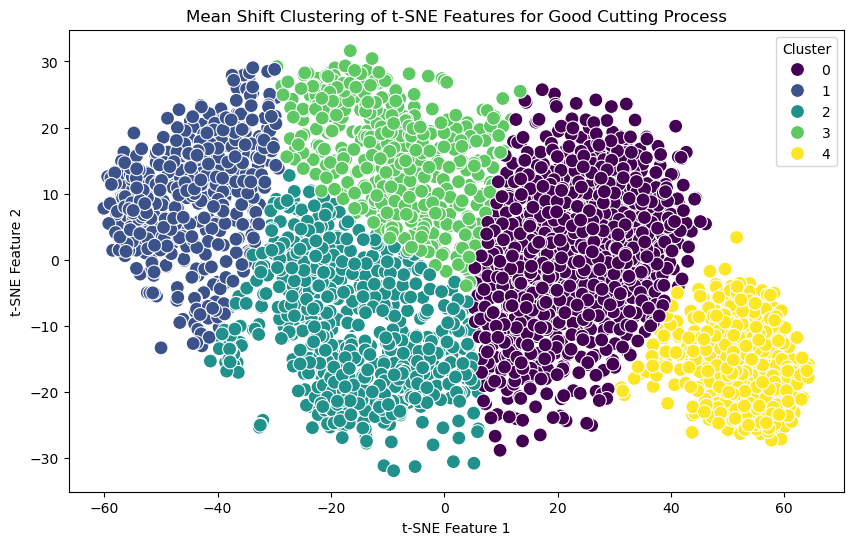

In [173]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Guess provided by Bosch 
# K is not needed for Mean Shift

# Select only the good predictions
good_indices = np.where(predictions == 1)[0]
good_features = unlabelled_scalo_features[good_indices]

# Reshape the selected good features to 2D (if needed)
good_features_reshaped = good_features.reshape(good_features.shape[0], -1)

# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(good_features_reshaped)

# Estimate the bandwidth for Mean Shift
bandwidth = estimate_bandwidth(tsne_results, quantile=0.1)

# Perform Mean Shift clustering on the t-SNE results
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift_labels = mean_shift.fit_predict(tsne_results)

# Visualize the t-SNE results with clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=mean_shift_labels, palette='viridis', s=100, alpha=1.0)
plt.title('Mean Shift Clustering of t-SNE Features for Good Cutting Process')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()


plt.figure(figsize=(10, 12))  # Increase figure size for a wider plot

## Mean Shift Clustering on Bad Data

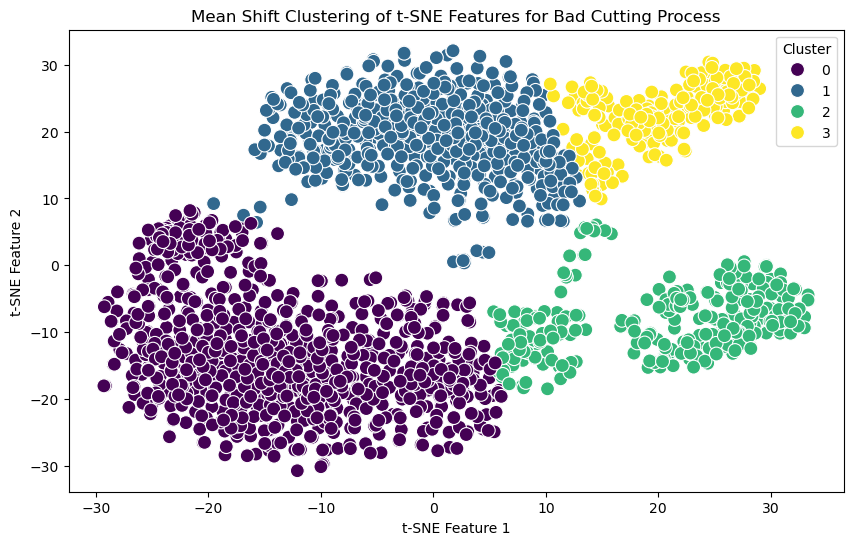

In [178]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Guess provided by Bosch 
# K is not needed for Mean Shift

# Select only the bad predictions
bad_indices = np.where(predictions == 0)[0]
bad_features = unlabelled_scalo_features[bad_indices]

# Reshape the selected bad features to 2D (if needed)
bad_features_reshaped = bad_features.reshape(bad_features.shape[0], -1)

# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(bad_features_reshaped)

# Estimate the bandwidth for Mean Shift
bandwidth = estimate_bandwidth(tsne_results, quantile=0.12)

# Perform Mean Shift clustering on the t-SNE results
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift_labels = mean_shift.fit_predict(tsne_results)

# Visualize the t-SNE results with clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=mean_shift_labels, palette='viridis', s=100, alpha=1.0)
plt.title('Mean Shift Clustering of t-SNE Features for Bad Cutting Process')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

## t-SNE with alpha values representing chronology

In [175]:
# import numpy as np
# from sklearn.manifold import TSNE
# from sklearn.cluster import MeanShift, estimate_bandwidth
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Initial Guess provided by Bosch 
# # K is not needed for Mean Shift

# # Select only the bad predictions
# bad_indices = np.where(predictions == 0)[0]
# bad_features = unlabelled_scalo_features[bad_indices]

# # Reshape the selected bad features to 2D (if needed)
# bad_features_reshaped = bad_features.reshape(bad_features.shape[0], -1)

# # Perform t-SNE analysis
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(bad_features_reshaped)

# # Estimate the bandwidth for Mean Shift
# bandwidth = estimate_bandwidth(tsne_results, quantile=0.1)

# # Perform Mean Shift clustering on the t-SNE results
# mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# mean_shift_labels = mean_shift.fit_predict(tsne_results)

# # Normalize indices for alpha values
# alpha_values = np.linspace(0.1, 1.0, len(tsne_results))

# # Visualize the t-SNE results with clustering and time-based alpha
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=mean_shift_labels, cmap='viridis', s=100, alpha=alpha_values)
# plt.title('Mean Shift Clustering of t-SNE Features for Bad Cutting Process')
# plt.xlabel('t-SNE Feature 1')
# plt.ylabel('t-SNE Feature 2')
# plt.colorbar(scatter, label='Cluster')
# plt.show()

## Gaussian Mixture Modelling

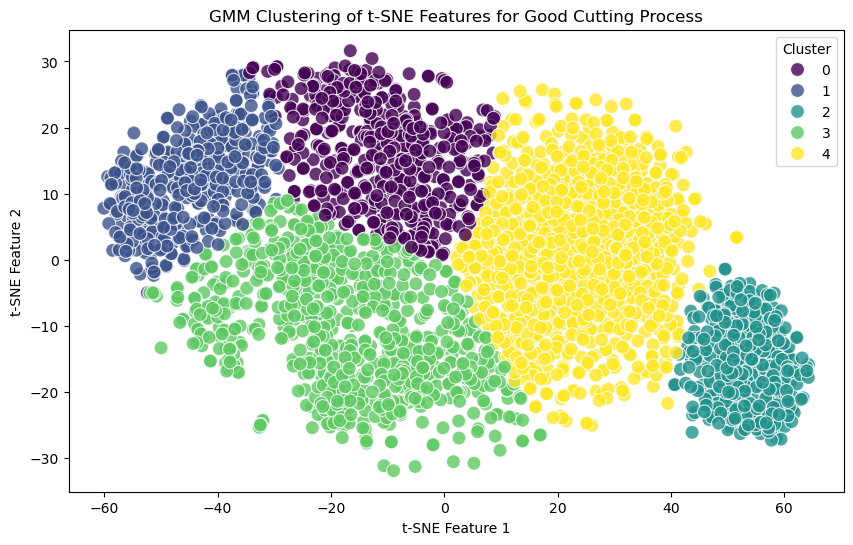

In [176]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the good predictions
good_indices = np.where(predictions == 1)[0]
good_features = unlabelled_scalo_features[good_indices]

# Reshape the selected good features to 2D (if needed)
good_features_reshaped = good_features.reshape(good_features.shape[0], -1)

# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(good_features_reshaped)

# Perform Gaussian Mixture Modeling on the t-SNE results
n_components = 5  # You can adjust this based on your data
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(tsne_results)

# Visualize the t-SNE results with GMM clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=gmm_labels, palette='viridis', s=100, alpha=0.8)
plt.title('GMM Clustering of t-SNE Features for Good Cutting Process')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

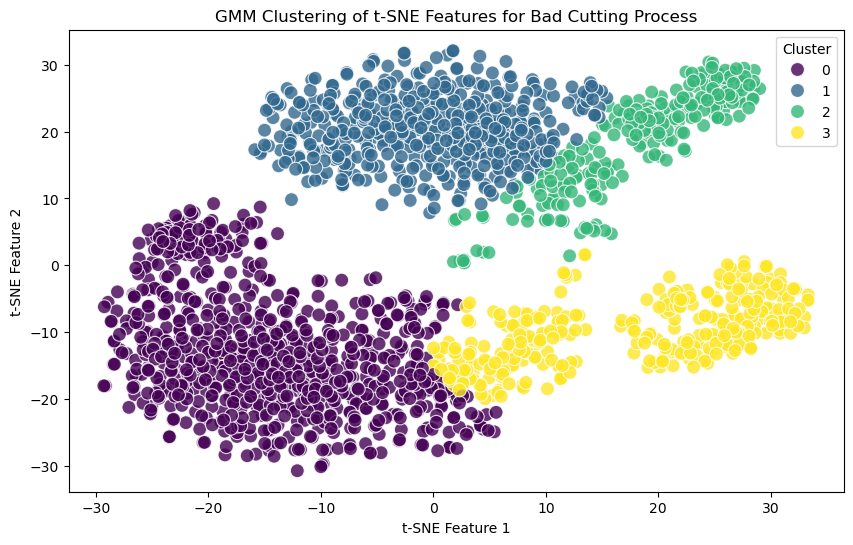

In [177]:

# Select only the bad predictions
bad_indices = np.where(predictions == 0)[0]
bad_features = unlabelled_scalo_features[bad_indices]

# Reshape the selected bad features to 2D (if needed)
bad_features_reshaped = bad_features.reshape(bad_features.shape[0], -1)

# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(bad_features_reshaped)

# Perform Gaussian Mixture Modeling on the t-SNE results
n_components = 4  # You can adjust this based on your data
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm_labels = gmm.fit_predict(tsne_results)

# Visualize the t-SNE results with GMM clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=gmm_labels, palette='viridis', s=100, alpha=0.8)
plt.title('GMM Clustering of t-SNE Features for Bad Cutting Process')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()